# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'aapl.csv')
df = df.iloc[:, 1:]
df

,Open,High,Low,Close,Volume,Close_SMA10,Close_SMA20,Close_SMA30,Close_EMA10,Close_EMA20,...,Close_long,Close_MACD,Close_SignalLine,Close_7D,Close_1D,Close_Momentum,Close1diff,Close_up,Close_down,Close_RSI
0,151.78,151.78,151.78,151.78,195.0,151.802,151.8685,151.851000,151.814923,151.837962,...,151.846566,-0.025605,-0.016996,151.80,151.80,0.000000,-0.02,0.00,-0.02,37.096774
1,151.78,151.78,151.78,151.78,465.0,151.803,151.8640,151.846333,151.808574,151.832442,...,151.841635,-0.026976,-0.018992,151.80,151.78,-0.000132,0.00,0.00,0.00,33.898305
2,151.75,151.75,151.65,151.69,1877.0,151.787,151.8525,151.837333,151.787015,151.818876,...,151.830403,-0.034922,-0.022178,151.81,151.78,-0.000198,-0.09,0.00,-0.09,28.358209
3,151.62,151.62,151.60,151.62,913.0,151.769,151.8365,151.826667,151.756648,151.799935,...,151.814817,-0.046334,-0.027009,151.81,151.69,-0.000790,-0.07,0.00,-0.07,29.687500
4,151.66,151.66,151.65,151.65,441.0,151.754,151.8210,151.824000,151.737258,151.785656,...,151.802609,-0.052353,-0.032078,151.81,151.62,-0.001252,0.03,0.03,0.00,22.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66784,166.28,166.33,166.28,166.33,1020.0,166.340,166.3450,166.359333,166.323779,166.337186,...,166.336513,-0.007955,0.005171,166.40,166.28,-0.000721,0.05,0.05,0.00,51.162791
66785,166.33,166.33,166.30,166.30,327.0,166.325,166.3450,166.351333,166.319455,166.333645,...,166.333808,-0.009644,0.002208,166.33,166.33,0.000000,-0.03,0.00,-0.03,42.307692
66786,166.30,166.35,166.30,166.35,3435.0,166.323,166.3500,166.349333,166.325009,166.335203,...,166.335008,-0.006868,0.000393,166.40,166.30,-0.000601,0.05,0.05,0.00,45.121951
66787,166.33,166.40,166.33,166.40,1519.0,166.323,166.3515,166.348667,166.338644,166.341374,...,166.339822,-0.000627,0.000189,166.35,166.35,0.000000,0.05,0.05,0.00,47.674419


### If you want Feature Engineering for uni-stock

In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #Simple Moving Average
    def SMA(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        data[column+f'_SMA{period}'] = data[column].rolling(period).mean()
        return data
    
    def SMA_(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        return data[column].rolling(period).mean()

    #Exponential Moving Average
    def EMA(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        data[column+f'_EMA{period}'] = data[column].ewm(span=period, adjust=False).mean()
        return data
    
    def EMA_(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        return data[column].ewm(span=period, adjust=False).mean()
    
    #BollingerBand with SMA
    def Bollingerband(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_SMA{period}'] = self.SMA_(data, column=column, period=period)
        data[column+'_UB'] = data[column+f'_SMA{period}'] + 2*data[column+f'_SMA{period}'].std()
        data[column+'_LB'] = data[column+f'_SMA{period}'] - 2*data[column+f'_SMA{period}'].std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'_short'] = self.EMA_(data, period=period_short, column=column)

        data[column+f'_long'] = self.EMA_(data, period=period_long, column=column)

        data[column+'_MACD'] = data[column+f'_short']- data[column+f'_long']

        #signal
        data[column+'_SignalLine'] = self.EMA_(data, period=period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_{period}D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+f'_{period}D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'1diff'] = data[column].diff(1)
        
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA_(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA_(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = copy.deepcopy(train)
        c = self.stock_name
        
        self.train = self.SMA(self.train, column=c, period=10)
        self.train = self.SMA(self.train, column=c, period=20)
        self.train = self.SMA(self.train, column=c, period=30)
        
        self.train = self.EMA(self.train, column=c, period=10)
        self.train = self.EMA(self.train, column=c, period=20)
        self.train = self.EMA(self.train, column=c, period=30)
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
#fe = FeatureEngineering('AAPL')
#df_fe = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
#df = pd.concat([df_fe.iloc[:, 1:], df], axis=1)
#df.dropna(inplace=True)
target_loc = pd.Index(df.columns.tolist()).get_loc('Close')
print(target_loc, len(df.columns))

3 24


In [7]:
train = df[:60000]
valid = df[60000:60000+3800]
test = df[60000+3800:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

60000 3800 2989


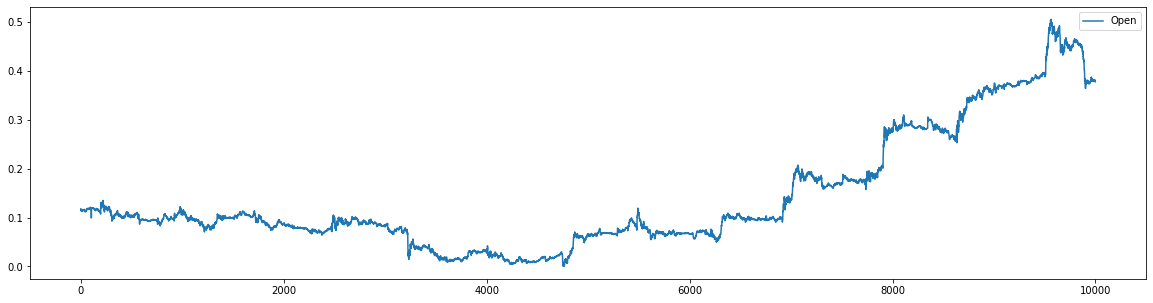

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, 0], label=train_sc.columns[0])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred, target_loc):
        self.data = torch.Tensor(data.values)
        self.window = window
        self.pred = pred
        self.target_loc = target_loc
        self.use_cols = [x for x in range(len(data.columns))] #if x != target_loc
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, self.use_cols]
        y = self.data[index+self.window+self.pred-1, self.target_loc]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4
window = 120
pred_step = 1

In [12]:
train_dataset = MyDataset(train_sc, window, pred_step, target_loc)
valid_dataset = MyDataset(valid_sc, window, pred_step, target_loc)
test_dataset = MyDataset(test_sc, window, pred_step, target_loc)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [13]:
result_folder = f'../check/gru/stock_prediction_{pred_step}_aapl/'
os.makedirs(result_folder, exist_ok=True)

In [14]:
class GRU(nn.Module):
    def __init__(self, in_features, out_features, hidden_dim):
        super(GRU, self).__init__()
        
        self.n_layers = 3
        self.hidden_size=hidden_dim
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.gru = nn.GRU(input_size=in_features, hidden_size=self.hidden_size, batch_first=True,
                          num_layers=self.n_layers, dropout=0.1)
        
        self.out = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            self.leakyrelu,
            nn.Linear(64, 32), 
            self.leakyrelu,
            nn.Linear(32, out_features)
        )
        
    def forward(self, x):
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, x.shape[0], self.hidden_size).zero_()
        
        rnn_output, h = self.gru(x,h)
        outputs = self.out(h[-1, :, :].squeeze(0))
        
        return outputs

In [15]:
model = GRU(in_features= 24,
            out_features=1, 
            hidden_dim = 256).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [16]:
model

GRU(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (gru): GRU(24, 256, num_layers=3, batch_first=True, dropout=0.1)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model Training & Evaluation #

In [17]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-stock-{epoch}.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'gru-pred-stock-best.pt')

epoch: 0/200 | trn_loss: 0.0405 | val_loss: 0.0107


epoch: 1/200 | trn_loss: 0.0094 | val_loss: 0.0084


epoch: 2/200 | trn_loss: 0.0088 | val_loss: 0.0060


epoch: 3/200 | trn_loss: 0.0079 | val_loss: 0.0056


epoch: 4/200 | trn_loss: 0.0074 | val_loss: 0.0072


epoch: 5/200 | trn_loss: 0.0067 | val_loss: 0.0055


epoch: 6/200 | trn_loss: 0.0066 | val_loss: 0.0051


epoch: 7/200 | trn_loss: 0.0064 | val_loss: 0.0052


epoch: 8/200 | trn_loss: 0.0061 | val_loss: 0.0062


epoch: 9/200 | trn_loss: 0.0059 | val_loss: 0.0063


epoch: 10/200 | trn_loss: 0.0057 | val_loss: 0.0048


epoch: 11/200 | trn_loss: 0.0055 | val_loss: 0.0071


epoch: 12/200 | trn_loss: 0.0056 | val_loss: 0.0048


epoch: 13/200 | trn_loss: 0.0055 | val_loss: 0.0055


epoch: 14/200 | trn_loss: 0.0054 | val_loss: 0.0049


epoch: 15/200 | trn_loss: 0.0053 | val_loss: 0.0063


epoch: 16/200 | trn_loss: 0.0052 | val_loss: 0.0046


epoch: 17/200 | trn_loss: 0.0052 | val_loss: 0.0055


epoch: 18/200 | trn_loss: 0.0051 | val_loss: 0.0058


epoch: 19/200 | trn_loss: 0.0049 | val_loss: 0.0055


epoch: 20/200 | trn_loss: 0.0050 | val_loss: 0.0046


epoch: 21/200 | trn_loss: 0.0049 | val_loss: 0.0048


epoch: 22/200 | trn_loss: 0.0047 | val_loss: 0.0044


epoch: 23/200 | trn_loss: 0.0048 | val_loss: 0.0043


epoch: 24/200 | trn_loss: 0.0047 | val_loss: 0.0051


epoch: 25/200 | trn_loss: 0.0047 | val_loss: 0.0042


epoch: 26/200 | trn_loss: 0.0047 | val_loss: 0.0042


epoch: 27/200 | trn_loss: 0.0047 | val_loss: 0.0053


epoch: 28/200 | trn_loss: 0.0046 | val_loss: 0.0043


epoch: 29/200 | trn_loss: 0.0046 | val_loss: 0.0041


epoch: 30/200 | trn_loss: 0.0045 | val_loss: 0.0043


epoch: 31/200 | trn_loss: 0.0046 | val_loss: 0.0046


epoch: 32/200 | trn_loss: 0.0043 | val_loss: 0.0042


epoch: 33/200 | trn_loss: 0.0045 | val_loss: 0.0045


epoch: 34/200 | trn_loss: 0.0043 | val_loss: 0.0048


epoch: 35/200 | trn_loss: 0.0044 | val_loss: 0.0040


epoch: 36/200 | trn_loss: 0.0044 | val_loss: 0.0050


epoch: 37/200 | trn_loss: 0.0043 | val_loss: 0.0057


epoch: 38/200 | trn_loss: 0.0045 | val_loss: 0.0041


epoch: 39/200 | trn_loss: 0.0043 | val_loss: 0.0053


epoch: 40/200 | trn_loss: 0.0043 | val_loss: 0.0053


epoch: 41/200 | trn_loss: 0.0043 | val_loss: 0.0051


epoch: 42/200 | trn_loss: 0.0043 | val_loss: 0.0041


epoch: 43/200 | trn_loss: 0.0045 | val_loss: 0.0040


epoch: 44/200 | trn_loss: 0.0043 | val_loss: 0.0042


epoch: 45/200 | trn_loss: 0.0043 | val_loss: 0.0040


epoch: 46/200 | trn_loss: 0.0043 | val_loss: 0.0041


epoch: 47/200 | trn_loss: 0.0042 | val_loss: 0.0049


epoch: 48/200 | trn_loss: 0.0042 | val_loss: 0.0044


epoch: 49/200 | trn_loss: 0.0042 | val_loss: 0.0042


epoch: 50/200 | trn_loss: 0.0043 | val_loss: 0.0059


epoch: 51/200 | trn_loss: 0.0043 | val_loss: 0.0040


epoch: 52/200 | trn_loss: 0.0042 | val_loss: 0.0043


epoch: 53/200 | trn_loss: 0.0042 | val_loss: 0.0042


epoch: 54/200 | trn_loss: 0.0042 | val_loss: 0.0056


epoch: 55/200 | trn_loss: 0.0043 | val_loss: 0.0040


epoch: 56/200 | trn_loss: 0.0042 | val_loss: 0.0044


KeyboardInterrupt: 

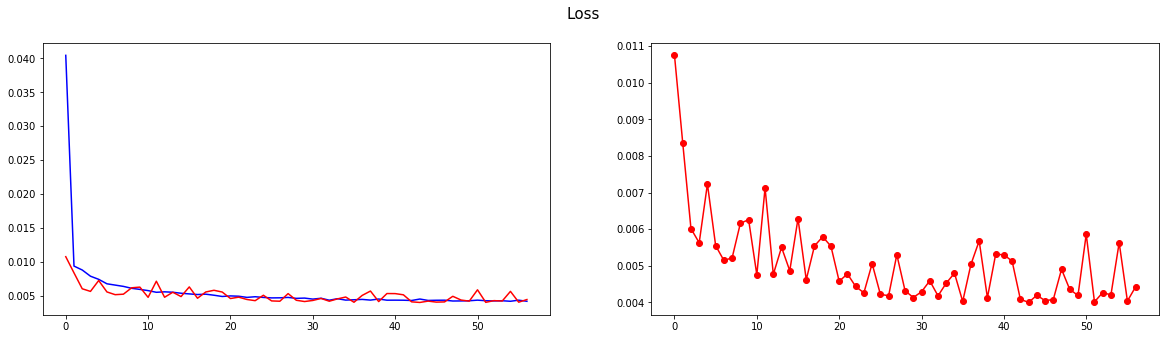

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'gru_loss.png')

In [19]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'gru_loss.csv', index=0)

### Performance Evaluation

In [20]:
checkpoint = torch.load(result_folder + 'gru-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

43 0.003997818145355017


In [21]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        answers.extend((y.squeeze()).squeeze().detach().cpu().numpy())
        predictions.extend((outputs.squeeze()).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

test loss: 0.0032958734677069716


In [22]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
print(answers.shape, predictions.shape, test_sc.shape)

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

(2928, 24) (2928, 24) (2989, 24)


In [23]:
print(result_ans.shape)

(2928, 24)


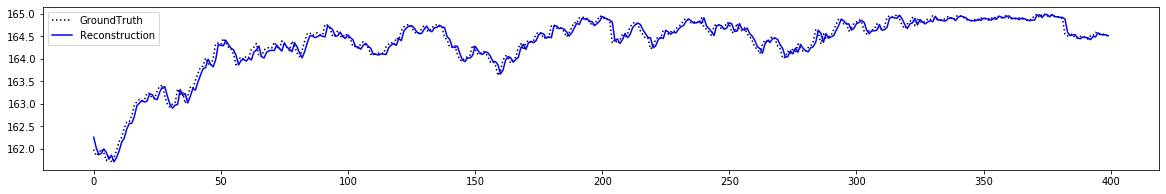

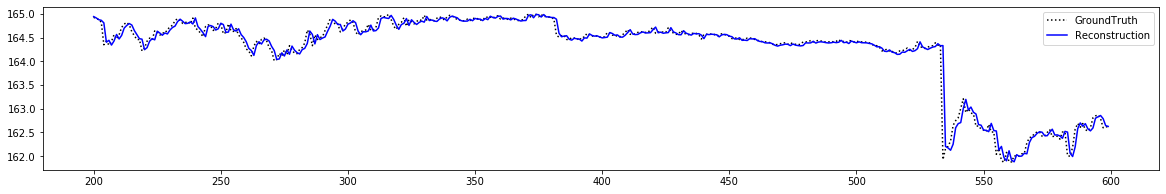

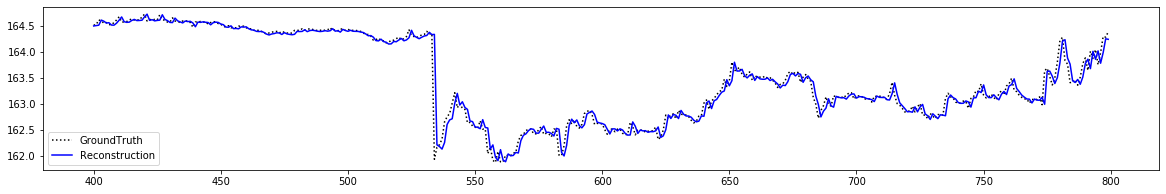

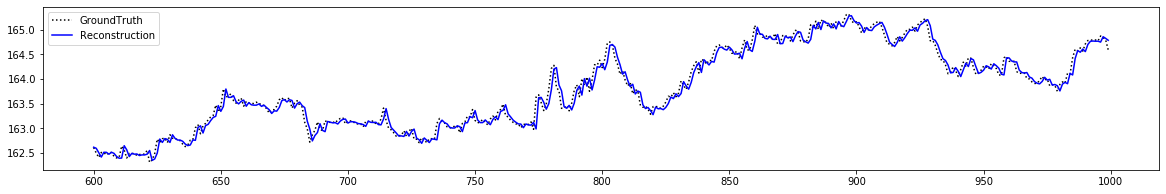

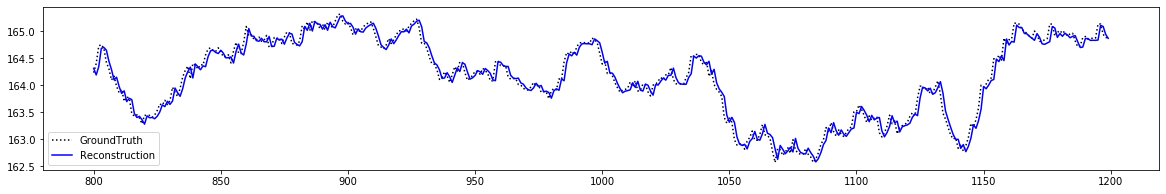

In [24]:
for i in range(0,1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()